# Data Preparation

In [1]:
import pandas as pd
import PIL
from PIL import Image
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

## Analysing Data Characteristics

In [2]:
root_path = 'GTSRB/Training/Images'

stats = pd.DataFrame()

for x in range(43):
    prefix = prefix = root_path + '/' + format(x, '05d') + '/'    # directory for each class
    gt_file_name = open(prefix + 'GT-'+ format(x, '05d') + '.csv')    # annotations file
    gt_file  = pd.read_csv(gt_file_name, delimiter = ';')    # read file
    stats = stats.append(gt_file)    # combine into 1 file
    
print(stats.describe())    # get stats

              Width        Height        Roi.X1        Roi.Y1        Roi.X2  \
count  39209.000000  39209.000000  39209.000000  39209.000000  39209.000000   
mean      50.835880     50.328930      5.999515      5.962381     45.197302   
std       24.306933     23.115423      1.475493      1.385440     23.060157   
min       25.000000     25.000000      0.000000      5.000000     20.000000   
25%       35.000000     35.000000      5.000000      5.000000     29.000000   
50%       43.000000     43.000000      6.000000      6.000000     38.000000   
75%       58.000000     58.000000      6.000000      6.000000     53.000000   
max      243.000000    225.000000     20.000000     20.000000    223.000000   

             Roi.Y2       ClassId  
count  39209.000000  39209.000000  
mean      44.728379     15.788390  
std       21.971145     12.013238  
min       20.000000      0.000000  
25%       30.000000      5.000000  
50%       38.000000     12.000000  
75%       52.000000     25.000000  


Looking at the statistics above, ** *32 x 32* ** is a suitable size for image resizing.

## Preprocessing the Data

### Helper functions

In [3]:
# Converts the labels into one-hot encoded format
def OneHotEncode(class_labels, num_classes):
    return np.eye(num_classes)[class_labels]

# Normalizes the image data
def normalizer(image_data):
    avg = np.mean(image_data, axis = 0)
    std = np.std(image_data, axis = 0)
    for i in range(len(image_data)):
        image_data[i] = (image_data[i] - avg) / std
    return image_data

### Loading, preprocessing and conslidating the training image data

   The following steps are performed:
   - Load the image and labels
   - Crop image to bounding box
   - Resize image to 32 x 32
   - Convert image to grayscale
   - Convert image values to floating point
   - Add to dataset the image and label

In [4]:
# Loading all the training images
train_images = []
train_labels = []

for x in range(43):
    
    prefix = prefix = root_path + '/' + format(x, '05d') + '/'    # directory for each class
    gt_file_name = open(prefix + 'GT-'+ format(x, '05d') + '.csv')    # annotations file
    gt_file  = pd.read_csv(gt_file_name, delimiter = ';')    # read file
    
    for index, row in gt_file.iterrows():
        image = Image.open(prefix + row[0])
        image = image.crop((row[3],row[4],row[5],row[6]))    # cropping to the bounding box
        image = image.resize((32,32), PIL.Image.ANTIALIAS)    # resizing the image 
        
        im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
        im_arr = im_arr.reshape((32, 32,3))    # converting to numpy array
        im_arr = cv2.cvtColor(im_arr, cv2.COLOR_RGB2GRAY)    # converting to grayscale
        im_arr = im_arr.reshape((32, 32,1))
        im_arr = im_arr.astype(np.float32 , copy= False)
        
        train_images.append(im_arr)
        train_labels.append(row[7])

train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)
                                
print(train_images.shape)

(39209, 32, 32, 1)


### Saving the image statistics to disk 
    These are to be used by the mobile application to normalize the input data

In [6]:
avg = np.mean(train_images, axis = 0)
std = np.std(train_images, axis = 0)

np.savetxt("avg.txt",avg)
np.savetxt("std.txt",std)

### Normalizing the image data

In [5]:
train_images = normalizer(train_images)

print(train_images.shape)

(39209, 32, 32, 1)


### Helper functions to visualize the data

In [30]:
# Returns indices of images in the dataset having the given class label
def class_indices(class_label, labels=train_labels):
    return np.where(labels == [class_label])[0]

# Plots a number of sample images belonging to the given class
def plot_class_samples(class_label, n=5,labels=train_labels, cmap='gray'):
        indices = np.random.choice(class_indices(class_label), n)
        figure = plt.figure(figsize = (8,8))
        
        for i, index in enumerate(indices):
            a = figure.add_subplot(n,n, i+1)
            plt.imshow(train_images[index].reshape((32,32)), interpolation='nearest', cmap=cmap)
            plt.axis('off')
        plt.suptitle('class {}'.format(class_label))
        plt.show()
        
# Plots samples from all the classes        
def plot_all():
    figure = plt.figure(figsize = (8,8))
        
    for i in range(43):
        index = np.random.choice(class_indices(i), 1)
        a = figure.add_subplot(8,8, i+1)
        plt.imshow(train_images[index].reshape((32,32)), interpolation='nearest', cmap='gray')
        plt.axis('off')
        if((i+1)%8 == 0):
            plt.show()
            figure = plt.figure(figsize = (8,8))
    plt.show()
        

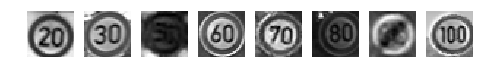

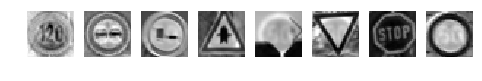

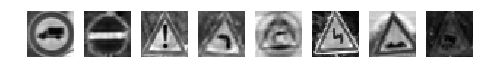

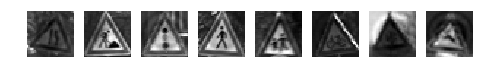

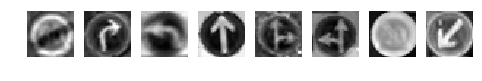

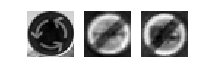

In [31]:
plot_all()

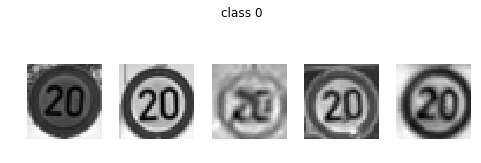

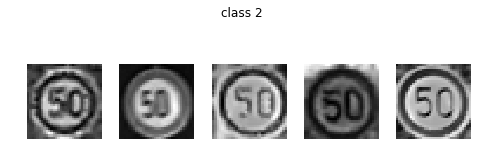

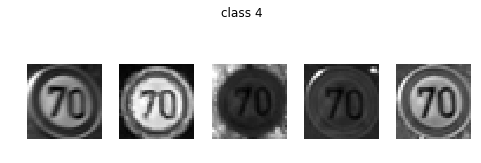

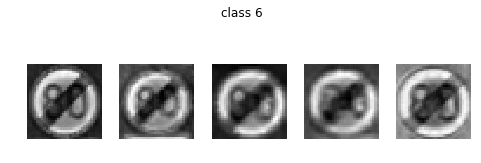

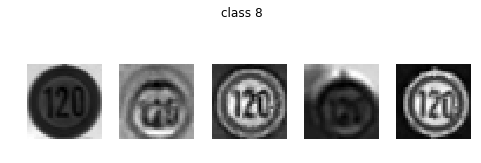

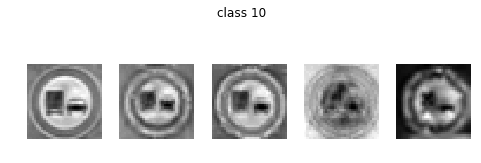

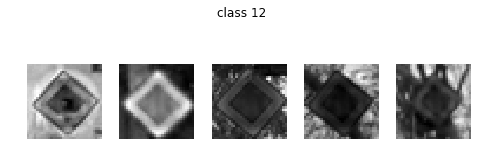

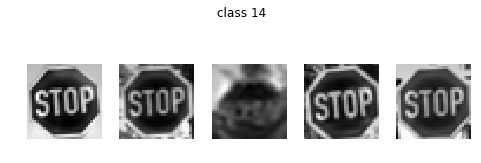

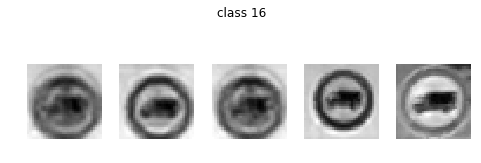

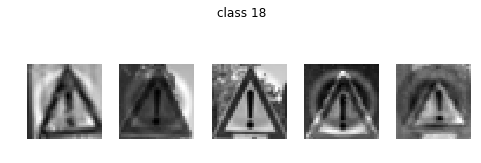

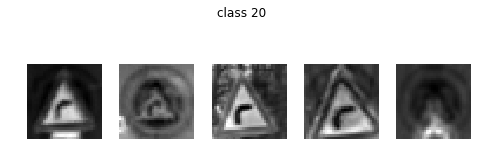

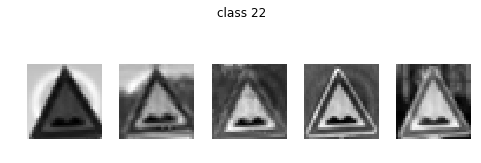

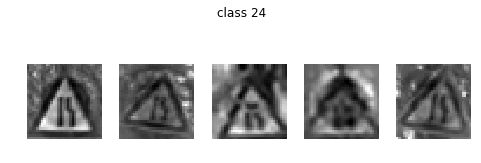

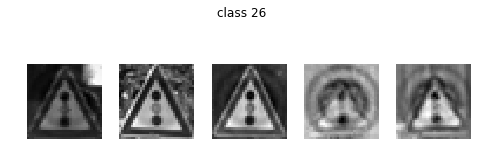

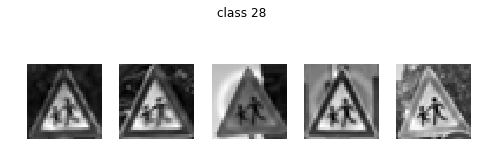

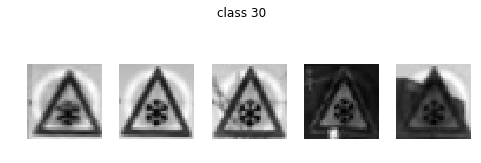

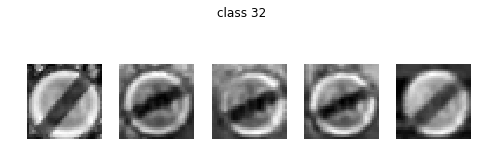

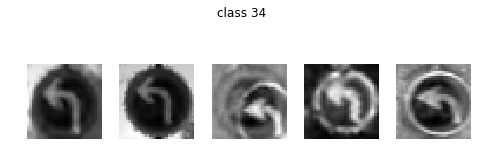

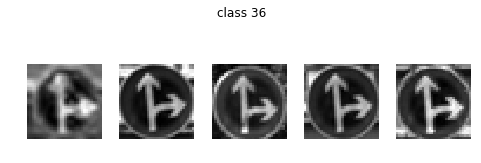

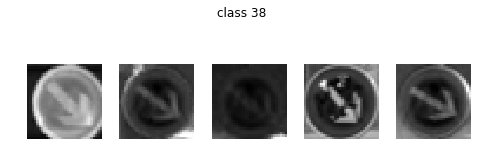

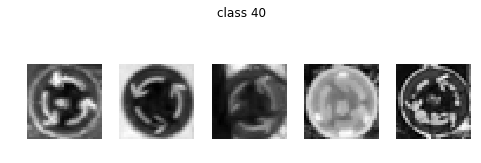

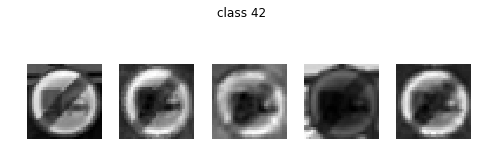

In [11]:
for i in range(0,43,2):
    plot_class_samples(i)

### Converting the labels to one-hot encoded format

In [8]:
train_labels = OneHotEncode(train_labels, 43)

print(train_labels.shape)

(39209, 43)


### Randomly Shuffling the Data

In [9]:
from sklearn.utils import shuffle

train_images, train_labels = shuffle(train_images, train_labels, random_state = 33)    # randomly shuffling data

### Saving Preprocessed Data to disk

In [10]:
pickle.dump(train_images, open('train_images32_final.pkl', 'wb'), protocol = pickle.HIGHEST_PROTOCOL)    # saving to disk
pickle.dump(train_labels, open('train_labels32_final.pkl', 'wb'), protocol = pickle.HIGHEST_PROTOCOL)    # saving to disk

### Loading, preprocessing and conslidating the testing image data

   The following steps are performed:
   - Load the image and labels
   - Crop image to bounding box
   - Resize image to 32 x 32
   - Convert image to grayscale
   - Convert image values to floating point
   - Add to dataset the image and label

In [ ]:
# Loading all the training images
test_images = []
test_labels = []

root_path = 'GTSRB/Final_Test/Images/'
gt_file  = pd.read_csv('GTSRB/Final_Test/Images/GT-final_test.csv', delimiter = ';')    # read file

for index, row in gt_file.iterrows():
    image = Image.open(root_path + row[0])
    image = image.crop((row[3],row[4],row[5],row[6]))    # cropping the image
    image = image.resize((32,32), PIL.Image.ANTIALIAS)    # resizing the image 
      
    im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
    im_arr = im_arr.reshape((32, 32,3))    # converting to numpy array
    im_arr = cv2.cvtColor(im_arr, cv2.COLOR_RGB2GRAY)    # converting to grayscale
    im_arr = im_arr.reshape((32, 32,1))
    im_arr = im_arr.astype(np.float32 , copy= False)
        
    test_images.append(im_arr)
    test_labels.append(row[7])

test_images = np.asarray(test_images)
test_labels = np.asarray(test_labels)
                                
print(test_images.shape)

### Normalizing the image data

In [ ]:
test_images = normalizer(test_images)

### Converting the labels to one-hot encoded format

In [ ]:
test_labels = OneHotEncode(test_labels, 43)

### Randomly Shuffling the Data

In [ ]:
test_images, test_labels = shuffle(test_images, test_labels, random_state = 91)    # randomly shuffling data

### Saving Preprocessed Data to disk

In [ ]:
pickle.dump(test_images, open('test_images32_final.pkl', 'wb'), protocol = pickle.HIGHEST_PROTOCOL)    # saving to disk
pickle.dump(test_labels, open('test_labels32_final.pkl', 'wb'), protocol = pickle.HIGHEST_PROTOCOL)    # saving to disk